In [1]:
# Ensure that GPU is selected: Runtime > Change runtime type

# This notebook is a streamlined version of the more detailed tutorial at:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Install the packages we need
%matplotlib inline
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set the random seed to ensure reproducibility
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Give the notebook access to Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Unzip the images locally
!unzip "gdrive/MyDrive/Dustin Garvey Shared/EAI6010 - Applications of AI/2021-07-23 Development/celebrity_faces.zip" 
print( "\n\n" )
os.listdir( )

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/celebrity_faces/img_align_celeba/._074351.jpg  
  inflating: celebrity_faces/img_align_celeba/108926.jpg  
  inflating: __MACOSX/celebrity_faces/img_align_celeba/._108926.jpg  
  inflating: celebrity_faces/img_align_celeba/136610.jpg  
  inflating: __MACOSX/celebrity_faces/img_align_celeba/._136610.jpg  
  inflating: celebrity_faces/img_align_celeba/120072.jpg  
  inflating: __MACOSX/celebrity_faces/img_align_celeba/._120072.jpg  
  inflating: celebrity_faces/img_align_celeba/062533.jpg  
  inflating: __MACOSX/celebrity_faces/img_align_celeba/._062533.jpg  
  inflating: celebrity_faces/img_align_celeba/166027.jpg  
  inflating: __MACOSX/celebrity_faces/img_align_celeba/._166027.jpg  
  inflating: celebrity_faces/img_align_celeba/024566.jpg  
  inflating: __MACOSX/celebrity_faces/img_align_celeba/._024566.jpg  
  inflating: celebrity_faces/img_align_celeba/169314.jpg  
  inflating: __MACOSX/celebrity_faces/img_alig

['.config', 'gdrive', 'celebrity_faces', '__MACOSX', 'sample_data']

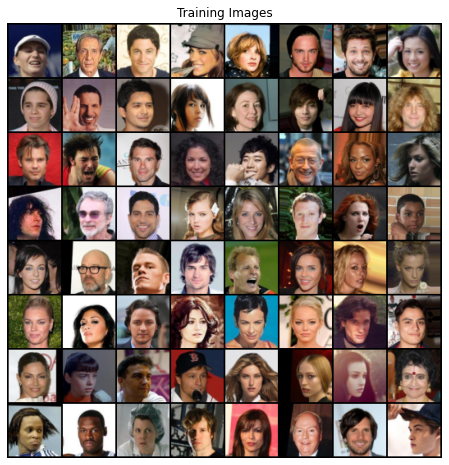

In [3]:
# Let's load the images from file
image_size = 64
dataset = dset.ImageFolder( 
    root = "celebrity_faces", # what directory contains the images
    transform = transforms.Compose( [ # what transform is applied to each image? 
                               transforms.Resize( image_size ), # make sure all images are the same size
                               transforms.CenterCrop( image_size ), # crop the image around the center -- this is supposed to reduce noise and if not present does not result in GAN convergence
                               transforms.ToTensor( ), #  the images need to be tensors
                               transforms.Normalize( ( 0.5, 0.5, 0.5 ), ( 0.5, 0.5, 0.5 ) ), # normalize to mean=0.5, standard deviation=0.5 for the 3 color channels
                               ] )
    )

# Create the dataloader
dataloader = torch.utils.data.DataLoader( dataset, batch_size = 128, shuffle = True, num_workers = 2 )

# Decide which device we want to run on
device = torch.device( "cuda:0" if torch.cuda.is_available( ) else "cpu" )

# Plot some training images
real_batch = next( iter( dataloader ) )
plt.figure( figsize = ( 8, 8 ) )
plt.axis( "off" )
plt.title( "Training Images" )
plt.imshow( np.transpose( vutils.make_grid( real_batch[0].to(device)[:64], padding=2, normalize=True ).cpu( ), ( 1, 2, 0 ) ) )

In [4]:
# Define the generator-discriminator model architectures

# Define some parameters
nc = 3 # number of color channels in the image, RGB = 3
nz = 100 # size of z latent vector (i.e. size of generator input)
ngf = 64 # size of the geneator feature maps
ndf = 64 # size of the discrimiator feature maps

# Generator architecture
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)

# Define the discrimiator architecture
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [5]:
# Create the network instances and setup for training

# Create a function for custom initialization of the network weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator
netG = Generator( 1 ).to( device )
netG.apply( weights_init )

# Create the discrimiator
netD = Discriminator( 1 ).to( device )
netD.apply( weights_init )

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn( 64, nz, 1, 1, device = device )

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [6]:
# Let's train the model.

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# For each epoch
print("Starting Training Loop...")
num_epochs = 1
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/1][0/1583]	Loss_D: 1.5662	Loss_G: 5.8256	D(x): 0.6126	D(G(z)): 0.5596 / 0.0047
[0/1][50/1583]	Loss_D: 0.6312	Loss_G: 20.5464	D(x): 0.9876	D(G(z)): 0.3796 / 0.0000
[0/1][100/1583]	Loss_D: 3.6402	Loss_G: 9.2060	D(x): 0.1186	D(G(z)): 0.0000 / 0.0003
[0/1][150/1583]	Loss_D: 0.5289	Loss_G: 3.2968	D(x): 0.7288	D(G(z)): 0.0548 / 0.0731
[0/1][200/1583]	Loss_D: 0.4707	Loss_G: 3.7156	D(x): 0.8721	D(G(z)): 0.2177 / 0.0372
[0/1][250/1583]	Loss_D: 0.3873	Loss_G: 3.6724	D(x): 0.8808	D(G(z)): 0.1372 / 0.0478
[0/1][300/1583]	Loss_D: 0.5671	Loss_G: 3.2230	D(x): 0.7232	D(G(z)): 0.0898 / 0.0644
[0/1][350/1583]	Loss_D: 0.7759	Loss_G: 2.7491	D(x): 0.5746	D(G(z)): 0.0213 / 0.1116
[0/1][400/1583]	Loss_D: 0.3929	Loss_G: 3.5906	D(x): 0.8831	D(G(z)): 0.1862 / 0.0503
[0/1][450/1583]	Loss_D: 0.6827	Loss_G: 3.6051	D(x): 0.6480	D(G(z)): 0.0157 / 0.0425
[0/1][500/1583]	Loss_D: 0.4850	Loss_G: 4.7807	D(x): 0.8757	D(G(z)): 0.2430 / 0.0141
[0/1][550/1583]	Loss_D: 0.8920	Loss_G: 5.3526	D(x): 

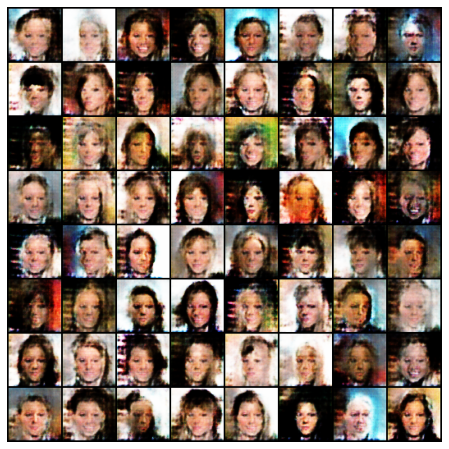

In [7]:
# Let's have a look at the generated images as we train the network
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

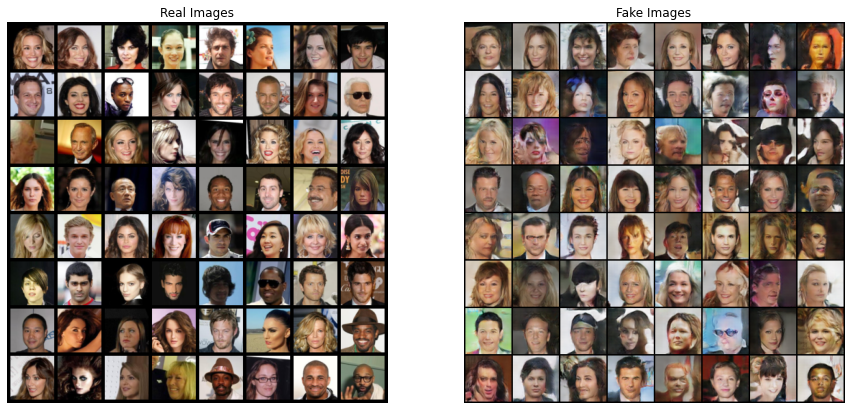

In [ ]:
# What would the results look like if we did 10 epochs instead of 1?

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()